# Assignment_6 

*EE2703: Applied Programming   
Author: Varun Sundar, EE16B068*

Conventions
1. We are using Python 3, GCC for C 
2. Underscore naming vs Camel Case 
3. PEP 25 convention style.

## Abstract

This weeks assignment concerns with solving for the simulation of a tublelight, in 1-Dimension. We make certain simplifying assumptions that allow us to simulate easily. 

## Introduction

Consider electrons being emitted by the cathode with zero energy, and accelerate in this field. When they get beyond a threshold energy $E_0$, they can drive atoms to excited states. The relaxation of these atoms results in light emission. In our model, we will assume that the relaxation is immediate. The electron loses all its energy and the process starts again.

Those electrons reaching the anode are absorbed and lost. Each “time step”, an average of $N$ electrons are introduced at the cathode. The actual number of electrons is determined by finding the integer part of a random number that is “normally distributed” (Gaussian Distributed) with standard deviation of 2 and mean 10.

## Code Description

We have wrapped the entire simulation into a class called, *Simulate_tubelight*, which creates the universe, then vectors. The simulation steps (which is run sequentially in a loop) is described below:

1. All electrons are constrained between $0<x<L$, anything out of range is set to $x=0,u=0$.
2. Displacement and Velocity are updated with time steps as: $dx_i =u_i\Delta t+\frac{a(\Delta t)}{2} =u_i+0.5$.
3. Determine which particles have hit the anode, reinitiate them to $(x=0,u=0)$.
4. Find out which electrons are sufficiently energised, together with a probability of collision, determine the number of photons emmited at a particular position.
5. Assuming inelastic collision, set their velocities to zero, and random position.
6. Inject a randomly distributed number of electrons, with the given mean $M$ and variance $M_sig$.
7. Compile a list of existing electrons into respective vectors.

The entire loop may be run iteratively using a class method.

In [404]:
import numpy as np
import matplotlib.pyplot as plt

In [407]:
class Simulate_tubelight(object):
    '''Simulate a tubelight'''
    def __init__(self,n=100,M=5,nk=1000,u0=7,p=0.5,Msig=0.2):
        self.create_universe(n,M,nk,u0,p,Msig)
        self.create_vectors()
    
    def create_universe(self,n=100,M=5,nk=1000,u0=7,p=0.5,Msig=0.2):
        self.n=n  # spatial grid size.
        self.M=M    # number of electrons injected per turn.
        self.nk=nk # number of turns to simulate.
        self.u0=u0  # threshold velocity.
        self.p=p # probability that ionization will occur
        self.Msig=Msig
        
    def create_vectors(self):
        dim=self.n*self.M 
        self.xx=np.zeros(dim) # Electron position 
        self.u=np.zeros(dim) # Electron velocity
        self.dx=np.zeros(dim) # Displacement in current turn
        self.I=[] # Intensity of emitted light,
        self.X=[] # Electron position
        self.V=[] # Electron velocity
        
    def loop(self):
        # Find the electrons present in the chamber.
        self.ii=np.where(self.xx>0)[0]
        
        # Compute the displacement during this turn
        self.dx[self.ii]=self.u[self.ii]+0.5

        # Advance the electron position and velocity for the turn.
        self.xx[self.ii]+=self.dx[self.ii]
        self.u[self.ii]+=1
        
        # Determine which particles have hit the anode
        self.hit_anode=np.where(self.xx>self.n)[0]
        self.xx[self.hit_anode]=0
        self.u[self.hit_anode]=0
        self.dx[self.hit_anode]=0
        
        # Find those electrons whose velocity is greater than or equal to the threshold.
        self.kk=np.where(self.u>=self.u0)[0]
        # Of these, which electrons are ionized
        self.ll=np.where(np.random.rand(len(self.kk))<=self.p)[0]
        self.kl=self.kk[self.ll]

        # Reset the velocities of these electrons to zero (they suffered an inelastic collision)
        self.u[self.kl]=0
        # The collision could have occurred at any point between the previous xi and the current xi
        self.xx[self.kl]-=self.dx[self.kl]*np.random.rand()

        # Excited atoms at this location resulted in emission from that point.
        self.I.extend(self.xx[self.kl].tolist())

        # Inject M new electrons
        m= int(np.random.randn()*self.Msig+self.M)  # actual number of electrons injected
        # Add them to unused slots. Adding randomly
        self.slots_to_add_to=np.where(self.xx==0)[0]

        if len(self.slots_to_add_to)>=m:
            random_start=np.random.randint(len(self.slots_to_add_to))
            self.xx[self.slots_to_add_to[random_start:m+random_start]]=1
            self.u[self.slots_to_add_to[random_start-m:random_start]]=0
        else: # If no free slots
            self.xx[self.slots_to_add_to]=1
            self.u[self.slots_to_add_to]=0
            
        self.existing_electrons=np.where(self.xx>0)[0]
        self.X.extend(self.xx[self.existing_electrons].tolist())
        self.V.extend(self.u[self.existing_electrons].tolist())
        
    def run_loop(self):
        [self.loop() for i in range(self.nk)]
        
    def plot_intensity(self):
        plt.hist(self.I,bins=np.arange(1,100),ec='black',alpha=0.5)
        plt.title("Light Intensity Histogram ")
        plt.show()
    
    def plot_electron_density(self):
        plt.hist(self.X,bins=np.arange(1,100),ec='black',alpha=0.5)
        plt.title("Electron Density Histogram")
        plt.show()
    
    def plot_intensity_table(self):
        import pandas
        a,bins,c=plt.hist(self.I,bins=np.arange(1,100),ec='black',alpha=0.5)
        xpos=0.5*(bins[0:-1]+bins[1:])
        d={'Position':xpos,'Count':a}
        p=pandas.DataFrame(data=d)
        print(p)
    
    def plot_electron_phase_space(self):
        plt.plot(self.xx,self.u,'x')
        plt.title("Electron Phase Space")
        plt.xlabel("Position")
        plt.figsize=(15,10)
        plt.ylabel("Velocity")
        plt.show()

The probability distribution for the displacement after collision is not uniform in space despite being uniform in time. This can be corrected using:

$$x=\frac{at^{2}}{2}$$ (when u=0)  

$$p_{X}(x)=p_{T}(t)*\frac {\partial t}{\partial x} $$.

We also write a code block to utilise system arguments to alter various paramters.

These are:

1. '-n', "--grid_size", help="Grid Size",default=100.
2. '-M','--no_of_electrons', help="Downscale ratio", default=5.
3. '-nk', '--turns', help="Number of iterations",default=500.
4. '-u0', '--threshold_velocity', help="Threshold Velocity for electron",default=500.
5. '-p', '--probability', help="Probability of collision",default=500.
6. '-Msig', '--variance', help="Variance of probability distribution".

In [397]:
import argparse as ap

if __name__=='__main__':
    parser = ap.ArgumentParser()
    parser.add_argument('-n', "--grid_size", help="Grid Size",default=100)
    parser.add_argument('-M','--no_of_electrons', help="Downscale ratio", default=5)
    parser.add_argument('-nk', '--turns', help="Number of iterations",default=500)
    parser.add_argument('-u0', '--threshold_velocity', help="Threshold Velocity for electron",default=7)
    parser.add_argument('-p', '--probability', help="Probability of collision",default=0.5)
    parser.add_argument('-Msig', '--variance', help="Variance of probability distribution ",default=0.2)
    args = vars(parser.parse_args())
    n,M,nk,u0,p,Msig=(args.grid_size,args.no_of_electrons,args.turns,args.threshold_velocity,\
                     args.probability,args.variance)
    a=Simulate_tubelight(n,M,nk,u0,p,Msig)

usage: ipykernel_launcher.py [-h] [-n GRID_SIZE] [-M NO_OF_ELECTRONS]
                             [-nk TURNS] [-u0 THRESHOLD_VELOCITY]
                             [-p PROBABILITY] [-Msig VARIANCE]
ipykernel_launcher.py: error: unrecognized arguments: -f /Users/Ankivarun/Library/Jupyter/runtime/kernel-0af91722-e69b-439a-a845-875dd6231d43.json


SystemExit: 2

/Users/Ankivarun/anaconda3/envs/tf_python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2918: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## Simulation Results

We plot the results for the values of:

1. '-n', "--grid_size", help="Grid Size", = 100.
2. '-M','--no_of_electrons', help="Downscale ratio", = 5.
3. '-nk', '--turns', help="Number of iterations",= 500.
4. '-u0', '--threshold_velocity', help="Threshold Velocity for electron",= 500.
5. '-p', '--probability', help="Probability of collision", = 500.
6. '-Msig', '--variance', help="Variance of probability distribution".

The following plots are made:

1. Electron Phase space plot (displacement - velocity)
2. Electron Density Histogram
3. Light Intensity Histogram
4. Intensity versus Displacement Table.

In [398]:
a=Simulate_tubelight()
a.run_loop()

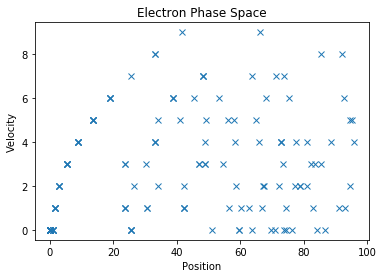

In [399]:
a.plot_electron_phase_space()

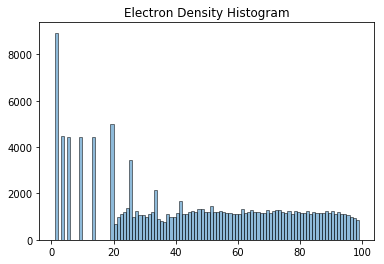

In [400]:
a.plot_electron_density()

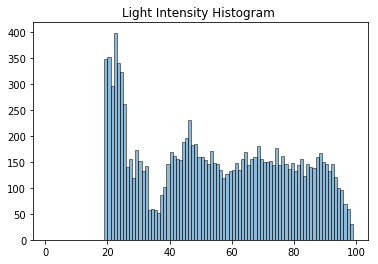

In [401]:
a.plot_intensity()

    Count  Position
0     0.0       1.5
1     0.0       2.5
2     0.0       3.5
3     0.0       4.5
4     0.0       5.5
5     0.0       6.5
6     0.0       7.5
7     0.0       8.5
8     0.0       9.5
9     0.0      10.5
10    0.0      11.5
11    0.0      12.5
12    0.0      13.5
13    0.0      14.5
14    0.0      15.5
15    0.0      16.5
16    0.0      17.5
17    0.0      18.5
18  348.0      19.5
19  352.0      20.5
20  295.0      21.5
21  398.0      22.5
22  340.0      23.5
23  322.0      24.5
24  261.0      25.5
25  139.0      26.5
26  156.0      27.5
27  118.0      28.5
28  172.0      29.5
29  152.0      30.5
..    ...       ...
68  156.0      69.5
69  150.0      70.5
70  150.0      71.5
71  152.0      72.5
72  144.0      73.5
73  176.0      74.5
74  144.0      75.5
75  161.0      76.5
76  145.0      77.5
77  136.0      78.5
78  147.0      79.5
79  133.0      80.5
80  144.0      81.5
81  155.0      82.5
82  123.0      83.5
83  146.0      84.5
84  140.0      85.5
85  138.0      86.5


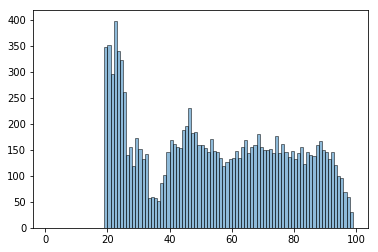

In [402]:
a.plot_intensity_table()

## Inference and Discussion

Firstly, the intensity histogram reveals that the electrons donot cause excitation of atoms til they cross a particular threshold velocity, as dictated by the nature of the gas used. Secondly, this gives rise to a peak in intensity just after the first mean length. This is beaucse a majority of electrons collide with atoms at this distance. Further this, subsequent peaks do exist, but have larger spread and are less prominent. We observer around 2 dark bands in this intensity profile.

The electron phase plots show the constant acceleration all electrons initially undergo, and the subsequent random motion post collision. The phase plots are nearly uniformly distributed in the middle portion of the tubelight.

## Altering Simulation Parameters

We try out the following set of parameters:

1. n=100, M = 5, nk =1000, u0=20, p=0.5,Msig=0.2 (larger threshold velocity).
2. n=100, M = 5, nk =1000, u0=7, p=0.1 ,Msig=0.2 (lower probabiltiy of collision).
3. n=100, M = 5, nk =1000, u0=7, p=0.1 ,Msig=4 (higher variance of randomness(normal variable)).

	 Parameter Case 	 1


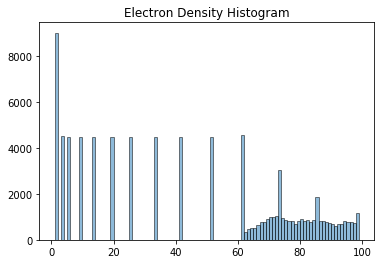

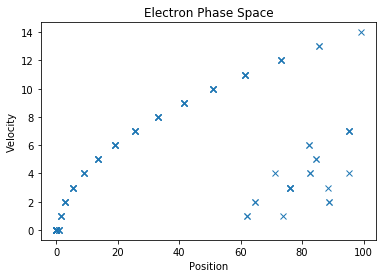

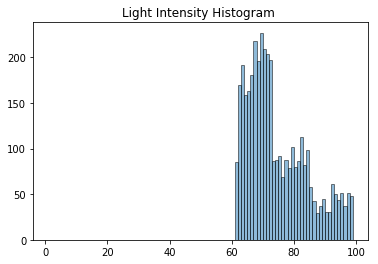

	 Parameter Case 	 2


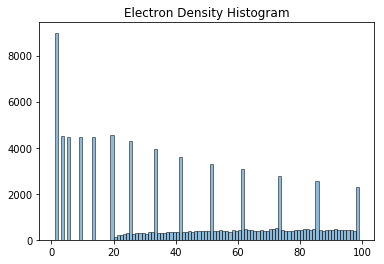

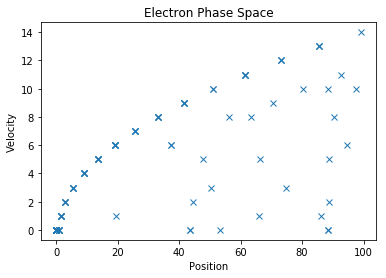

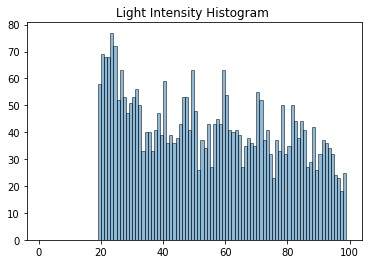

	 Parameter Case 	 3


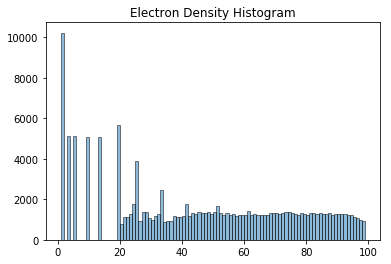

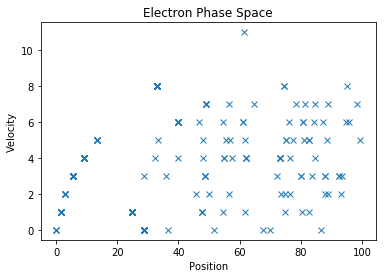

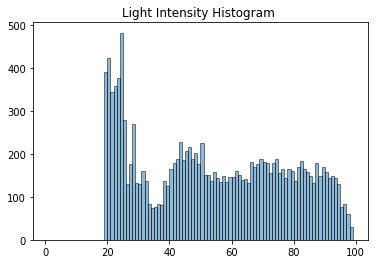

In [413]:
List_of_params=[(100, 5, 1000,12,0.5,0.2 ),(100, 5, 1000,7,0.1,0.2 ),(100, 5, 1000,7,0.5,4 )]

for params,i in zip(List_of_params,range(len(List_of_params))):
    n,M,nk,u0,p,Msig=params
    print("\t Parameter Case \t",i+1)
    a=Simulate_tubelight(n,M,nk,u0,p,Msig)
    a.run_loop()
    a.plot_electron_density()
    a.plot_electron_phase_space()
    a.plot_intensity()

### Results of Altered Parameters

1. Gives us a longer distance until first peak. If we cross the length of the tubelight, we see no emmision. The acceleration region of the phase space too has increased.
2. Lowers the intensity of the first peak. However, there are now more local maxima's in the intensity histogram.
3. Increases the overall intensity of light, while lowering those of minimae. 

## Conclusion

This week's assignment covers using python to simulate models for various requirements. In this case,we utilsise it for simualting electron motion in a tubelight, and hence find out the illumination at different points. The existence of an initial peak, and those of dark patches. In the subsequent sections, we also went over the effect of changing various parameters including probability of collision, threshold velocities and standard deviation.